# L4 - Word embedding

**Векторное представление слов (word embedding)** - общее название для различных подходов к моделированию языка и обучению представлений в обработке естественного языка, направленных на сопоставление словам из некоторого словаря векторов из $\mathbb{R}^n$, где $n$ значительно меньше размера словаря. Показано, что векторные представления слов пособно значительно улучшить качество работы некоторых методов автоматической обработки естественного языка, например, синтаксический анализ или анализ тональности.

Обычно задача нахождения представленя сводится к обучению без учителя на большом корпусе текста. А процесс обучения основывается на том, что контекст слова тестно связан с ним самим. К примеру, контекстом может быть документ, в котором это слово находится, или соседние слова.

In [1]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
logger=logging.getLogger(__name__)
import gensim.matutils
from gensim.corpora import WikiCorpus, MmCorpus, Dictionary
from gensim.models import TfidfModel
import pandas as pd
import scipy.spatial
import sklearn.decomposition
from collections import Counter, defaultdict
from random import shuffle
import collections
import random

import numpy as np
import tensorflow as tf
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from IPython.display import Image
random.seed(0xFEEDF00D)
np.random.seed(0xDEADBEEF)
tf.set_random_seed(0xCAFEBABE)

2017-02-24 22:25:30,696 : INFO : 'pattern' package not found; tag filters are not available for English


## Данные

**Задание**
1. Удобным для вас способом выкачайте себе обучающий корпус текста.
2. Подговьте статьи для процесса обучения, в частности нужно убрать всю разметку. Поработать с редко встречающимися словами, тут бывают разные техники.

В качестве корпуса будем использовать дамп [Simple English Wikipedia](https://dumps.wikimedia.org/simplewiki/20170201/simplewiki-20170201-pages-articles.xml.bz2) от 1 февраля 2017 года, предобработка статей осуществляется посредством библиотеки gensim. При этом после парсинга отбрасываются все слова, встречающиеся чаще, чем в 15% документов и реже, чем 10 раз.

In [2]:
outp='simplewiki'
wiki = WikiCorpus(outp+'-20170201-pages-articles.xml.bz2', lemmatize=False)
wiki.dictionary.filter_extremes(10,0.15,keep_n=100000)
tfidf = TfidfModel(wiki, id2word=wiki.dictionary, normalize=True)
vm=set(map(lambda x:x.encode(),wiki.dictionary.values()))

2017-02-24 22:25:32,823 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-02-24 22:25:41,337 : INFO : adding document #10000 to Dictionary(142655 unique tokens: ['ぴゃ', 'hayyan', 'osasuna', 'earthenware', 'haar']...)
2017-02-24 22:25:48,376 : INFO : adding document #20000 to Dictionary(203853 unique tokens: ['majaliwa', 'osasuna', 'morhange', 'dieren', 'esta']...)
2017-02-24 22:25:57,143 : INFO : adding document #30000 to Dictionary(258964 unique tokens: ['majaliwa', 'osasuna', 'morhange', 'dieren', 'jeonghee']...)
2017-02-24 22:26:04,980 : INFO : adding document #40000 to Dictionary(299935 unique tokens: ['bodices', 'majaliwa', 'osasuna', 'morhange', 'dieren']...)
2017-02-24 22:26:12,317 : INFO : adding document #50000 to Dictionary(363113 unique tokens: ['osasuna', 'zeddicus', 'jeonghee', 'slatina', 'dart']...)
2017-02-24 22:26:20,013 : INFO : adding document #60000 to Dictionary(406691 unique tokens: ['reshot', 'rudozem', 'osasuna', 'zeddicus', 'jeonghee']...)
2017-

## LSA (Latent semantic analysis)

**Задание**
1. Вычислите $X$, понравившимся способом (возможно, стоит использовать разреженную матрицу).
2. Обучите представлении слов $k = 128$ на своем корпусе.
3. Реализуйте поиск k-ближайших соседей для Евклидовой меры в 128-мерном пространстве .
4. Найдите 10 ближайших представлений к 30 словам, которые выбрали сами. Попытайтесь сделать так, чтобы примеры были интересными.
5. Проделайте то же самое для косинусной меры. Какой результат вам показался более интересным?
6. Предложите свою меру длины, проверьте, как она работает.

In [3]:
svd=sklearn.decomposition.TruncatedSVD(n_components=128)
emb_svd=svd.fit_transform(gensim.matutils.corpus2csc(tfidf[wiki],num_docs=wiki.length,num_terms=len(wiki.dictionary)))
del tfidf

2017-02-24 22:28:47,693 : INFO : finished iterating over Wikipedia corpus of 80817 documents with 21819318 positions (total 225974 articles, 23132907 positions before pruning articles shorter than 50 words)


In [4]:
def get_nn(word,matrix,id2word,word2id,metric=scipy.spatial.distance.cosine,k=10):
    ident=word2id(word)
    dists=[metric(matrix[ident],i) for i in matrix]
    return [id2word(i) for i in np.array(dists).argsort()[:k+1] if i!=ident][:k]
def get_sub_add_nn(word,sub,add,mat,id2word,word2id,metric=scipy.spatial.distance.cosine,k=10):
    rest_ind=[word2id(x) for x in [word,sub,add]]
    v=mat[word2id(word)]-mat[word2id(sub)]+mat[word2id(add)]
    dists=[metric(v,i) for i in mat]
    return [id2word(i) for i in np.array(dists).argsort()[:k+3] if i not in rest_ind][:k]
def get_neighbors_dataframe(word,matrix,id2word,word2id,k=10):
    return pd.DataFrame([
                    get_nn(word,matrix,
                                id2word,
                                word2id,
                                scipy.spatial.distance.euclidean,k),
                    get_nn(word,matrix,
                                id2word,
                                word2id,
                                scipy.spatial.distance.cosine,k),
                    get_nn(word,matrix,
                                id2word,
                                word2id,
                                scipy.spatial.distance.cityblock,k)],
                  index=['Euclidean','Cosine','Manhattan'],
                  columns=np.arange(1,k+1)).T

Наряду с евклидовой и косинусной рассмотрим манхэттенскую метрику:
$$\sum_{i=1}^n |p_i-q_i|$$

In [6]:
wiki.dictionary.doc2bow(['king'])

[(42140, 1)]

In [7]:
get_neighbors_dataframe('king',emb_svd,lambda x: wiki.dictionary[x],lambda x: wiki.dictionary.doc2bow([x])[0][0],10)

,Euclidean,Cosine,Manhattan
1,henry,ethelred,henry
2,ii,canute,ii
3,england,atheling,iii
4,iii,aethelred,edward
5,edward,kingship,queen
6,charles,unready,charles
7,son,athelstan,england
8,queen,rollo,son
9,william,wessex,william
10,duke,fealty,duke


In [ ]:
get_neighbors_dataframe('queen',emb_svd,lambda x: wiki.dictionary[x],lambda x: wiki.dictionary.doc2bow([x])[0][0])

In [ ]:
get_neighbors_dataframe('russia',emb_svd,lambda x: wiki.dictionary[x],lambda x: wiki.dictionary.doc2bow([x])[0][0])

In [ ]:
get_neighbors_dataframe('cat',emb_svd,lambda x: wiki.dictionary[x],lambda x: wiki.dictionary.doc2bow([x])[0][0])

In [ ]:
get_neighbors_dataframe('skillful',emb_svd,lambda x: wiki.dictionary[x],lambda x: wiki.dictionary.doc2bow([x])[0][0])

In [ ]:
get_neighbors_dataframe('rock',emb_svd,lambda x: wiki.dictionary[x],lambda x: wiki.dictionary.doc2bow([x])[0][0])

In [ ]:
get_neighbors_dataframe('mean',emb_svd,lambda x: wiki.dictionary[x],lambda x: wiki.dictionary.doc2bow([x])[0][0]

In [ ]:
get_neighbors_dataframe('variance',emb_svd,lambda x: wiki.dictionary[x],lambda x: wiki.dictionary.doc2bow([x])[0][0])

In [ ]:
get_neighbors_dataframe('default',emb_svd,lambda x: wiki.dictionary[x],lambda x: wiki.dictionary.doc2bow([x])[0][0])

In [ ]:
get_neighbors_dataframe('set',emb_svd,lambda x: wiki.dictionary[x],lambda x: wiki.dictionary.doc2bow([x])[0][0])

In [ ]:
get_neighbors_dataframe('actor',emb_svd,lambda x: wiki.dictionary[x],lambda x: wiki.dictionary.doc2bow([x])[0][0])

In [ ]:
get_neighbors_dataframe('era',emb_svd,lambda x: wiki.dictionary[x],lambda x: wiki.dictionary.doc2bow([x])[0][0])

In [ ]:
get_neighbors_dataframe('performance',emb_svd,lambda x: wiki.dictionary[x],lambda x: wiki.dictionary.doc2bow([x])[0][0])

In [ ]:
get_neighbors_dataframe('thousand',emb_svd,lambda x: wiki.dictionary[x],lambda x: wiki.dictionary.doc2bow([x])[0][0])

In [ ]:
get_neighbors_dataframe('general',emb_svd,lambda x: wiki.dictionary[x],lambda x: wiki.dictionary.doc2bow([x])[0][0])

In [ ]:
get_neighbors_dataframe('facebook',emb_svd,lambda x: wiki.dictionary[x],lambda x: wiki.dictionary.doc2bow([x])[0][0])

In [ ]:
get_neighbors_dataframe('apple',emb_svd,lambda x: wiki.dictionary[x],lambda x: wiki.dictionary.doc2bow([x])[0][0])

In [ ]:
get_neighbors_dataframe('them',emb_svd,lambda x: wiki.dictionary[x],lambda x: wiki.dictionary.doc2bow([x])[0][0])

In [ ]:
get_neighbors_dataframe('couple',emb_svd,lambda x: wiki.dictionary[x],lambda x: wiki.dictionary.doc2bow([x])[0][0])

In [ ]:
get_neighbors_dataframe('river',emb_svd,lambda x: wiki.dictionary[x],lambda x: wiki.dictionary.doc2bow([x])[0][0])

In [ ]:
get_neighbors_dataframe('everest',emb_svd,lambda x: wiki.dictionary[x],lambda x: wiki.dictionary.doc2bow([x])[0][0])

In [ ]:
get_neighbors_dataframe('player',emb_svd,lambda x: wiki.dictionary[x],lambda x: wiki.dictionary.doc2bow([x])[0][0])

In [ ]:
get_neighbors_dataframe('lasso',emb_svd,lambda x: wiki.dictionary[x],lambda x: wiki.dictionary.doc2bow([x])[0][0])

In [ ]:
get_neighbors_dataframe('cube',emb_svd,lambda x: wiki.dictionary[x],lambda x: wiki.dictionary.doc2bow([x])[0][0])

In [ ]:
get_neighbors_dataframe('article',emb_svd,lambda x: wiki.dictionary[x],lambda x: wiki.dictionary.doc2bow([x])[0][0])

In [ ]:
get_neighbors_dataframe('exoplanet',emb_svd,lambda x: wiki.dictionary[x],lambda x: wiki.dictionary.doc2bow([x])[0][0])

In [ ]:
get_neighbors_dataframe('handgun',emb_svd,lambda x: wiki.dictionary[x],lambda x: wiki.dictionary.doc2bow([x])[0][0])

In [ ]:
get_neighbors_dataframe('lipstick',emb_svd,lambda x: wiki.dictionary[x],lambda x: wiki.dictionary.doc2bow([x])[0][0])

In [ ]:
get_neighbors_dataframe('bus',emb_svd,lambda x: wiki.dictionary[x],lambda x: wiki.dictionary.doc2bow([x])[0][0])

In [ ]:
get_neighbors_dataframe('word',emb_svd,lambda x: wiki.dictionary[x],lambda x: wiki.dictionary.doc2bow([x])[0][0])

## word2vec

Теперь рассмотрим, пожалуй, одну из самых популярных моделей представления слов. В основном это связано с тем, что полученные вектора обладают интересными свойствами. В частности, похожие по смыслу слова являются близкими векторами, более того линейная операция вычитания имеют смысл в полученном векторном прострастве! Контекстом для слова на этот раз является некоторое скользящее окно размера $2c+1$, где интересующее нас слово занимает среднюю позицию.

### Предсказание слова по контексту (Continuous bag-of-words)
Идея, на которой основывается модель, очень проста. Пусть у нас есть корпус текста
$$w_1, w_2, \dots, w_T.$$
Рассмотрим некоторое слово $w_t$ и его контекст радиуса $c$, а именно слова 
$$w_{t-c}, \dots, w_{t-1}, w_{t+1}, \dots w_{t+c}.$$
Интуиция нам подсказывает, что контекст очень хорошо характеризует слово. Поэтому мы попытаемся обучить такую модель, которая по контесту восстаналивает центральное слово
$$\mathcal{L} = - \frac{1}{T}\sum_{t} \mathbb{P}[w_t|w_{t-c}, \dots, w_{t-1}, w_{t+1}, \dots w_{t+c}].$$

Пусть для каждого слова $w_t$ есть некоторое представление $v_t$, а когда слово $w_t$ входит в чей-то контекст, то мы будем кодировать его с помощью $v'_{t}$. Тогда весь контекст слова $w_t$ можно описать суммой
$$s'_t = \sum_{c \leq i \leq c, i \neq 0} v'_{t+i}$$

Таким образом искомую вероятность мы будем приближать следующей моделью
$$\mathbb{P}[w_t|w_{t-c}, \dots, w_{t-1}, w_{t-1}, \dots w_{t+c}] = \frac{ \exp {s'}_t^T \cdot v_t}{\sum_j \exp {s'}_t^T \cdot v_j}.$$

Заметим, что подобную модель несложно представить в виде простейшей нейронной сети:
* На вход подается разреженный вектор, где единичка стоят на позициях, соответствующих словам контекста.
* Далее идет полносвязанный слой, который состоит из векторов $v'$.
* Далее без применения какой-либо нелинейности идет матрица, состоящая из $v$.
* А затем слой softmax.

### Предсказание контекста по слову (Skip-gram)
Другая модель, которая чаще применяется на практике, пытается по слову предсказать его контекст. Конструкция примерно та же самая, нужно оптимизировать
$$\mathcal{L} = \frac{1}{T} \sum_t \sum_{-c \leq i \leq c, i \neq 0}\log \mathbb{P}[w_{t+i}|w_t].$$

При этом вероятность аппроксимируется следующей моделью
$$\mathbb{P}[w_{t+i}|w_t] = \frac{ \exp {v'}_{t+i}^T \cdot v_t}{\sum_j \exp {v'}_{j}^T \cdot v_t}.$$

**Задание**
1. Как можно представить модель skip-gram в виде нейронной сети?
2. Оцените сложность обучения skip-gram модели относительно параметров 
  * $T$ - размер корпуса
  * $W$ - размер словаря 
  * $c$ - радиус окна
  * $d$ - размерность представлений

1. Модель практически аналогична варианту CBOW, основные отличия истекают из того, что мы теперь предсказываем контекст:
    * Входной вектор - разреженный, единица стоит на позиции, ему соответствующей.
    * Первым полносвязным слоем мы получаем $h:=v_{w_i}^T$ - вектор, полученный умножением матрицы $W$ на входной. Из свойств входного вектора получаем, что данный вектор является искомым представлением слова. 
    * Затем, рассматривая некоторое число контекстов, мы вначале умножаем $h$ на ещё одну матрицу $\widetilde{W}$ ("матрицу контекстов"), а затем используем softmax для определения вероятности нахождения тех или иных слов в контексте входного. 
    * Функция ошибки в данном случае - среднее арифметическое суммы логарифмов правдоподобия нахождения слов в контексте входного по всем словам из входной выборки.
2. Если считать, что значения softmax известны после прохода вперёд, получаем следующую сложность:
    * Перемножение матриц: $1\times W \cdot W\times D$ для первого слоя, $1\times D \cdot D\times W$ для второго - сложность $O(WD)$.
    * Softmax: подсчёт $O(W)$, так как произведение уже выполнено и остаётся только разделить его на сумму экспонент всех остальных элементов вектора. Однако нам необходимо просуммировать их логарифмы для $O(C)$ слов из контекста, поэтому на данном этапе получаем $O(WC)$.
    * При обучении нам важны производные функции ошибки по двум матрицам представлений. Используя найденную ранее производную softmax, а также уравнения для обратного распространения ошибки, получаем, что в формулу будет входить произведение вектора $v_t$ и softmax всех $C$ контекстов, что даст нам операцию сложности $O(WCD)$, которая и будет доминирующей при вычислении.
    * Так как процесс необходимо повторить для каждого элемента в корпусе (или каждого батча, число которых также по логике должно быть пропорционально их размеру), асимптотическая сложность алгоритма дополнительно умножается на $T$. Получаем $O(TWCD)$.

### Аппроксимация softmax

На самом деле Миколов, создавая свою модель, руководствовался тем, чтобы сократить сложность обучения. Однако вычисление знаменателя в softmax является дорогой операцией, так как необхоидмо проходить по всему словарю. Поэтому на практике обучаются несколько иные модели, которые пытаются аппроксимировать поведение softmax.

#### Negative Sampling

Данная функция потерь является упращением **Noise contrastive estimation**, которая в свою очередь является аппроксимацией softmax. Суть в том, что можно попробовать оптимизировать функцию, сильно похожу на логистическую регрессию.

$$\mathcal{L} = - \frac{1}{T}\sum_{w_t}
    \sum_{-c \leq i \leq c, i \neq 0} \Big(
        \mathbb{P}[y = 1 | w_{t+i}, w_t] -
        k \cdot \mathbb{E}_{\tilde{w}_{tj} \sim \mathbb{P}[w_j|w_t]} \mathbb{P}[y = 0 | \tilde{w}_{tj}, w_t],
    \Big)
$$
где $y=1$, если одно слово является контекстом другого и 0 в обратном случае. А $\tilde{w}_{tj}$ - это специально семплированный слова, который не принадлежат контексту.


Дальше вся игра заключается в том, как мы распишем соответствующее распределение $\mathbb{P}[y | w_{t+i}, w_t]$. В [noise contrastive estimation](https://www.cs.helsinki.fi/u/ahyvarin/papers/Gutmann10AISTATS.pdf) есть свои навороты. Миколов же предлагает оптимизировать

$$\mathcal{L} = - \frac{1}{T}\sum_{w_t} \Big(
    \sum_{-c \leq i \leq c, i \neq 0} \big(
        \sigma({v'}_{t+i}^T v_t) +
        k \cdot \mathbb{E}_{w_j \sim \mathbb{Q}(w_j)} \sigma (-{v'}_{j}^T v_t)
    \big)
\Big),
$$

где для вычисления математического ожидания мы просто делаем $k$ семплов из какого-то распределения $\mathbb{Q}$ на словах, то есть $\mathbb{P}(w_j|w_t) = \mathbb{Q}(w_j)$.


**Задание**
1. Выберите понравивщуюся вам функцию потерь. Оцените сложность обучения для нее, сравните с простым softmax.
2. На основе оценки сложности определиться с количеством эпох, размера вектора $d$ = 256 будет достаточно. Определитесь с размером окна. Будьте готовы, что на большом корпусе обучение может длиться около суток.
2. Обучите skip-gram модель.
3. Попробуйте снова найти ближайшие представления для тех 30 слов. Улучшился ли результат визуально? Попробуйте разные меры расстояния (евклидова, косинусная).
4. Найдите ближайшие вектора для выражения v(king) - v(man) + v(women). Если модель обучена хорошо, то среди ближайших векторов должно быть представление v(queen). 


Оценим сложность при обучении Noise Contrastive Estimation:

  * Зависимость от $T,C,D$ практически аналогичная, а так как умножение матриц будет являться неотъемлемой частью любой модели, далее исключим включающее в себя $W$ выражение из оценки сложности.
  * Важнее отсутствие softmax, заменённое отбором $k$ примеров не из контекста рассматриваемого слова. Так как $k<<W$ на практике, то данный этап будет работать за $O(k)$, а значит, значительно быстрее, и итоговая сложность составит $O(TCDk)$.

In [8]:
vocabulary_size = len(wiki.dictionary)

def build_dataset():
    count=[]
    counter=collections.Counter()
    dictionary = {}
    data = []
    for line in wiki.get_texts():
        l=[i.decode() for i in line if i in vm]
        counter.update(l)
        data.extend(l)
    count.extend(counter.most_common(vocabulary_size))
    dictionary={count[i][0]:i for i in range(len(count))}
    data=[dictionary[word] for word in data]
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reverse_dictionary


data, count, dictionary, reverse_dictionary = build_dataset()
print('Most common words', count[:5])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])

data_index = 0

2017-02-24 22:33:08,839 : INFO : finished iterating over Wikipedia corpus of 80817 documents with 21819318 positions (total 225974 articles, 23132907 positions before pruning articles shorter than 50 words)


Most common words [('she', 41005), ('her', 31267), ('city', 30980), ('th', 29436), ('de', 24499)]
Sample data [49, 837, 799, 9, 512, 26, 35, 127, 797, 345] ['april', 'fourth', 'month', 'year', 'comes', 'between', 'march', 'four', 'months', 'days']


In [9]:
# Step 4: Build and train a skip-gram model.

batch_size = 256
embedding_size = 256    # Dimension of the embedding vector.
skip_window = 3             # How many words to consider left and right.
num_skips = 4                 # How many times to reuse an input to generate a label.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16         # Random set of words to evaluate similarity on.
valid_window = 100    # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64        # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default():

    # Input data.
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Ops and variables pinned to the CPU because of missing GPU implementation
    with tf.device('/cpu:0'):
        # Look up embeddings for inputs.
        embeddings = tf.Variable(
                tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
        embed = tf.nn.embedding_lookup(embeddings, train_inputs)

        # Construct the variables for the NCE loss
        nce_weights = tf.Variable(
                tf.truncated_normal([vocabulary_size, embedding_size],
                                                        stddev=1.0 / np.sqrt(embedding_size)))
        nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # Compute the average NCE loss for the batch.
    # tf.nce_loss automatically draws a new sample of the negative labels each
    # time we evaluate the loss.
    loss = tf.reduce_mean(
            tf.nn.nce_loss(weights=nce_weights,
                                         biases=nce_biases,
                                         labels=train_labels,
                                         inputs=embed,
                                         num_sampled=num_sampled,
                                         num_classes=vocabulary_size))

    # Construct the SGD optimizer using a learning rate of 1.0.
    optimizer = tf.train.AdagradOptimizer(1).minimize(loss)

    # Compute the cosine similarity between minibatch examples and all embeddings.
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(
            normalized_embeddings, valid_dataset)
    similarity = tf.matmul(
            valid_embeddings, normalized_embeddings, transpose_b=True)

    # Add variable initializer.
    init = tf.global_variables_initializer()

In [10]:
# Step 3: Function to generate a training batch for the skip-gram model.
def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1    # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window    # target label at the center of the buffer
        targets_to_avoid = [skip_window]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    # Backtrack a little bit to avoid skipping words in the end of a batch
    data_index = (data_index + len(data) - span) % len(data)
    return batch, labels

batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
for i in range(8):
        print(batch[i], reverse_dictionary[batch[i]],'->', labels[i, 0], reverse_dictionary[labels[i, 0]])

837 fourth -> 49 april
837 fourth -> 799 month
799 month -> 837 fourth
799 month -> 9 year
9 year -> 512 comes
9 year -> 799 month
512 comes -> 26 between
512 comes -> 9 year


In [11]:
# Step 5: Begin training.
num_steps = 500000

with tf.Session(graph=graph) as session:
    # We must initialize all variables before we use them.
    init.run()
    print("Initialized")
    average_loss = 0
    for step in range(num_steps):
        batch_inputs, batch_labels = generate_batch(
                batch_size, num_skips, skip_window)
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

        # We perform one update step by evaluating the optimizer op (including it
        # in the list of returned values for session.run()
        _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 20000 == 0:
            if step > 0:
                average_loss /= 20000
            print("Average loss at step ", step, ": ", average_loss)
            average_loss = 0
        if step % 100000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8    # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                log_str = "Nearest to %s:" % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log_str = "%s %s," % (log_str, close_word)
                print(log_str)
    final_embeddings = embeddings.eval()

Initialized
Average loss at step  0 :  290.420928955
Nearest to since: horseman, fontenay, condemned, plosive, simplest, mirroring, sudamericana, gully,
Nearest to april: noord, plein, bac, restrictions, addicted, dictator, esophagus, valerius,
Nearest to th: dobzhansky, thule, vinyl, prowse, clarice, bishopric, liberalism, nihonshoki,
Nearest to where: thought, inherits, crowns, shafer, ctesiphon, amnesia, paranaense, variants,
Nearest to family: puppies, laxman, esmeralda, florentin, ra, starved, assimilated, nasty,
Nearest to usually: agen, urs, schuster, firewall, nesbitt, central, alexa, valour,
Nearest to did: coastline, manuals, olimpia, sulu, comedy, lidia, copland, caius,
Nearest to august: commercials, unharmed, iu, mariah, gridcolor, martigny, olafur, destroy,
Nearest to st: takeda, trinité, natasha, thrust, discuss, malhotra, leandro, tropic,
Nearest to group: keio, ramparts, thrusting, ux, gyula, operationally, kerouac, bores,
Nearest to then: chola, refused, modern, klm, 

In [12]:
get_neighbors_dataframe('king',final_embeddings,lambda x: reverse_dictionary[x],lambda x: dictionary[x])

,Euclidean,Cosine,Manhattan
1,later,kingdom,kingdom
2,kingdom,queen,later
3,him,son,him
4,father,throne,them
5,soon,later,she
6,before,iii,then
7,she,father,until
8,queen,edward,returned
9,then,him,father
10,son,henry,before


In [14]:
get_neighbors_dataframe('queen',final_embeddings,lambda x: reverse_dictionary[x],lambda x: dictionary[x])

,Euclidean,Cosine,Manhattan
1,elizabeth,elizabeth,elizabeth
2,daughter,daughter,daughter
3,she,king,king
4,king,princess,she
5,her,kingdom,her
6,kingdom,she,kingdom
7,wife,wife,wife
8,father,mary,although
9,later,prince,father
10,mary,throne,later


In [15]:
get_neighbors_dataframe('russia',final_embeddings,lambda x: reverse_dictionary[x],lambda x: dictionary[x])

,Euclidean,Cosine,Manhattan
1,russian,russian,russian
2,soviet,soviet,europe
3,moscow,moscow,them
4,europe,ukraine,china
5,china,poland,moscow
6,them,bulgaria,today
7,now,finland,soviet
8,well,europe,such
9,said,lithuania,actually
10,although,china,said


In [16]:
get_neighbors_dataframe('cat',final_embeddings,lambda x: reverse_dictionary[x],lambda x: dictionary[x])

,Euclidean,Cosine,Manhattan
1,while,dog,while
2,always,viviers,actually
3,actually,long,still
4,dog,conjunto,just
5,said,baby,being
6,whose,meaning,today
7,just,while,near
8,being,toy,probably
9,reason,girl,like
10,although,friends,description


In [17]:
get_neighbors_dataframe('skillful',final_embeddings,lambda x: reverse_dictionary[x],lambda x: dictionary[x])

,Euclidean,Cosine,Manhattan
1,become,gelasius,fit
2,fit,landscaped,actually
3,actually,quinton,feel
4,highly,neuropathy,become
5,use,bebe,expensive
6,go,rabbinic,dress
7,run,farmington,bring
8,themselves,inexpensive,themselves
9,even,lavalette,scientists
10,though,humanoid,strongly


In [18]:
get_neighbors_dataframe('rock',final_embeddings,lambda x: reverse_dictionary[x],lambda x: dictionary[x])

,Euclidean,Cosine,Manhattan
1,pop,pop,pop
2,alternative,alternative,such
3,band,band,band
4,song,bands,alternative
5,where,folk,history
6,dance,hop,another
7,said,metal,like
8,being,dance,just
9,probably,rocks,started
10,while,roll,way


In [19]:
get_neighbors_dataframe('mean',final_embeddings,lambda x: reverse_dictionary[x],lambda x: dictionary[x])

,Euclidean,Cosine,Manhattan
1,means,means,means
2,like,meaning,thought
3,meaning,say,refer
4,although,word,said
5,another,refer,meaning
6,sometimes,like,like
7,simply,describe,say
8,always,see,see
9,thought,thing,describe
10,say,thought,although


In [20]:
get_neighbors_dataframe('variance',final_embeddings,lambda x: reverse_dictionary[x],lambda x: dictionary[x])

,Euclidean,Cosine,Manhattan
1,technical,esc,fields
2,scientific,vulpes,technical
3,claims,nrc,safety
4,specific,expositions,distinct
5,activity,cabal,claims
6,distinct,sunbury,why
7,way,honeycomb,chosen
8,reason,larnaca,thus
9,makes,abstain,resulting
10,fields,denoting,elements


In [21]:
get_neighbors_dataframe('default',final_embeddings,lambda x: reverse_dictionary[x],lambda x: dictionary[x])

,Euclidean,Cosine,Manhattan
1,depending,depending,depending
2,needed,necessary,required
3,allows,interface,using
4,necessary,allows,according
5,using,applications,needed
6,according,needed,will
7,purpose,according,information
8,applications,choose,particular
9,will,using,stated
10,support,purpose,support


In [22]:
get_neighbors_dataframe('set',final_embeddings,lambda x: reverse_dictionary[x],lambda x: dictionary[x])

,Euclidean,Cosine,Manhattan
1,another,sets,another
2,using,another,such
3,particular,put,any
4,both,follows,followed
5,possible,follow,same
6,put,each,etc
7,such,addition,being
8,however,number,possible
9,same,same,using
10,these,point,particular


In [23]:
get_neighbors_dataframe('actor',final_embeddings,lambda x: reverse_dictionary[x],lambda x: dictionary[x])

,Euclidean,Cosine,Manhattan
1,actress,actress,actress
2,musician,musician,musician
3,writer,comedian,well
4,comedian,songwriter,writer
5,director,writer,leading
6,songwriter,director,director
7,movie,singer,comedian
8,singer,screenwriter,movie
9,leading,movie,although
10,cast,producer,songwriter


In [24]:
get_neighbors_dataframe('era',final_embeddings,lambda x: reverse_dictionary[x],lambda x: dictionary[x])

,Euclidean,Cosine,Manhattan
1,beginning,period,beginning
2,period,beginning,period
3,end,pre,history
4,history,late,however
5,however,end,early
6,since,culture,end
7,modern,earliest,since
8,especially,modern,being
9,culture,early,described
10,today,traditional,although


In [25]:
get_neighbors_dataframe('performance',final_embeddings,lambda x: reverse_dictionary[x],lambda x: dictionary[x])

,Euclidean,Cosine,Manhattan
1,although,best,although
2,best,performances,however
3,result,award,best
4,leading,concert,well
5,single,musical,leading
6,particular,actor,considered
7,song,actress,song
8,simply,feature,included
9,however,supporting,single
10,another,pop,simply


In [26]:
get_neighbors_dataframe('thousand',final_embeddings,lambda x: reverse_dictionary[x],lambda x: dictionary[x])

,Euclidean,Cosine,Manhattan
1,hundred,hundred,hundred
2,over,thousands,over
3,thousands,approximately,thousands
4,nearly,over,nearly
5,ten,ten,ten
6,them,times,around
7,approximately,estimated,them
8,around,nearly,approximately
9,almost,millions,these
10,five,twenty,times


In [27]:
get_neighbors_dataframe('general',final_embeddings,lambda x: reverse_dictionary[x],lambda x: dictionary[x])

,Euclidean,Cosine,Manhattan
1,both,governor,both
2,later,appointed,later
3,etc,both,instead
4,said,promoted,etc
5,instead,lieutenant,said
6,although,president,although
7,well,later,however
8,created,terms,terms
9,then,led,created
10,however,manager,then


In [28]:
get_neighbors_dataframe('facebook',final_embeddings,lambda x: reverse_dictionary[x],lambda x: dictionary[x])

,Euclidean,Cosine,Manhattan
1,site,site,site
2,youtube,youtube,articles
3,page,page,page
4,official,official,users
5,users,users,youtube
6,website,fan,website
7,stated,org,official
8,without,website,without
9,allows,access,fan
10,fan,internet,watch


In [29]:
get_neighbors_dataframe('apple',final_embeddings,lambda x: reverse_dictionary[x],lambda x: dictionary[x])

,Euclidean,Cosine,Manhattan
1,although,tree,instead
2,instead,mac,although
3,use,fruit,being
4,being,originally,while
5,using,mobile,having
6,originally,inc,use
7,commonly,os,tree
8,another,version,yet
9,own,company,example
10,having,computers,another


In [30]:
get_neighbors_dataframe('them',final_embeddings,lambda x: reverse_dictionary[x],lambda x: dictionary[x])

,Euclidean,Cosine,Manhattan
1,others,others,others
2,instead,help,instead
3,help,try,help
4,while,him,both
5,him,themselves,while
6,themselves,instead,him
7,try,able,themselves
8,both,make,try
9,however,will,often
10,those,get,could


In [31]:
get_neighbors_dataframe('couple',final_embeddings,lambda x: reverse_dictionary[x],lambda x: dictionary[x])

,Euclidean,Cosine,Manhattan
1,married,married,married
2,whom,marriage,whom
3,children,divorced,children
4,wife,sons,sons
5,daughter,daughter,daughter
6,sons,wife,she
7,she,children,wife
8,marriage,whom,parents
9,although,daughters,marriage
10,while,parents,later


In [32]:
get_neighbors_dataframe('river',final_embeddings,lambda x: reverse_dictionary[x],lambda x: dictionary[x])

,Euclidean,Cosine,Manhattan
1,rivers,rivers,near
2,near,flows,rivers
3,valley,valley,town
4,west,near,city
5,town,west,west
6,along,joins,area
7,state,south,valley
8,city,town,another
9,area,north,along
10,flows,state,just


In [33]:
get_neighbors_dataframe('everest',final_embeddings,lambda x: reverse_dictionary[x],lambda x: dictionary[x])

,Euclidean,Cosine,Manhattan
1,mountain,mountain,above
2,actually,climb,actually
3,above,mount,climb
4,highly,above,reach
5,due,erupts,sometimes
6,however,highest,mountain
7,reach,elevation,highest
8,rise,metres,both
9,mount,newts,due
10,although,summit,commonly


In [34]:
get_neighbors_dataframe('player',final_embeddings,lambda x: reverse_dictionary[x],lambda x: dictionary[x])

,Euclidean,Cosine,Manhattan
1,players,players,players
2,footballer,footballer,footballer
3,team,team,team
4,played,club,club
5,club,played,played
6,playing,football,coach
7,coach,goals,play
8,manager,coach,playing
9,football,manager,just
10,play,playing,him


In [35]:
get_neighbors_dataframe('lasso',final_embeddings,lambda x: reverse_dictionary[x],lambda x: dictionary[x])

,Euclidean,Cosine,Manhattan
1,tiny,khazar,tiny
2,said,blackett,trans
3,closer,mork,gilbert
4,bernard,typographical,tim
5,others,ballantyne,arthur
6,day,gries,closer
7,uses,dern,uses
8,still,transportes,recognition
9,predators,pople,orange
10,orlando,esc,pianist


In [36]:
get_neighbors_dataframe('cube',final_embeddings,lambda x: reverse_dictionary[x],lambda x: dictionary[x])

,Euclidean,Cosine,Manhattan
1,figure,curve,almost
2,both,corners,figure
3,dr,figure,six
4,almost,sides,wrong
5,fit,rapper,different
6,usually,exactly,way
7,song,dimensional,nearly
8,peter,fit,doing
9,original,singles,original
10,simply,rocket,both


In [37]:
get_neighbors_dataframe('article',final_embeddings,lambda x: reverse_dictionary[x],lambda x: dictionary[x])

,Euclidean,Cosine,Manhattan
1,described,articles,described
2,page,page,page
3,way,biography,history
4,articles,issue,way
5,history,described,see
6,using,journal,own
7,case,information,always
8,issue,reference,author
9,see,online,issue
10,information,see,case


In [38]:
get_neighbors_dataframe('exoplanet',final_embeddings,lambda x: reverse_dictionary[x],lambda x: dictionary[x])

,Euclidean,Cosine,Manhattan
1,mars,mars,research
2,launched,launched,found
3,research,pictures,mars
4,pictures,research,carried
5,found,distributed,scientific
6,recent,spacecraft,according
7,project,archaeology,launched
8,around,archaeological,books
9,according,impacts,periods
10,bodies,walt,les


In [39]:
get_neighbors_dataframe('handgun',final_embeddings,lambda x: reverse_dictionary[x],lambda x: dictionary[x])

,Euclidean,Cosine,Manhattan
1,duplicate,mj,duplicate
2,jeri,kalimantan,wrangler
3,latium,unsupported,ucsd
4,snapshots,ly,jeri
5,bowed,sunbury,ngos
6,houten,mystics,installer
7,meditate,cardboard,snapshots
8,motionless,dutton,collette
9,soles,tenggara,houten
10,wrangler,metis,misconception


In [40]:
get_neighbors_dataframe('lipstick',final_embeddings,lambda x: reverse_dictionary[x],lambda x: dictionary[x])

,Euclidean,Cosine,Manhattan
1,lies,thrift,kid
2,holding,dll,leading
3,whose,mythic,lies
4,kid,abstain,holding
5,own,anubis,famous
6,figures,chilena,barack
7,always,weissmuller,check
8,leading,honeycomb,danger
9,young,transportes,fit
10,fact,gnomes,killing


In [41]:
get_neighbors_dataframe('bus',final_embeddings,lambda x: reverse_dictionary[x],lambda x: dictionary[x])

,Euclidean,Cosine,Manhattan
1,train,train,train
2,being,transport,usually
3,usually,buses,generally
4,while,rail,being
5,another,car,set
6,them,yulara,typically
7,simply,vehicle,simply
8,generally,services,cannot
9,normal,gb,etc
10,etc,via,using


In [42]:
get_neighbors_dataframe('word',final_embeddings,lambda x: reverse_dictionary[x],lambda x: dictionary[x])

,Euclidean,Cosine,Manhattan
1,meaning,meaning,meaning
2,words,words,means
3,means,means,words
4,sometimes,comes,sometimes
5,comes,term,comes
6,term,sometimes,simply
7,simply,latin,another
8,mean,phrase,term
9,another,simply,often
10,latin,mean,mean


In [43]:
get_sub_add_nn('king','man','woman',final_embeddings,lambda x: reverse_dictionary[x],lambda x: dictionary[x])

['she',
 'daughter',
 'later',
 'kingdom',
 'queen',
 'throne',
 'soon',
 'wife',
 'returned',
 'then']

На основе арифметических операций над представлениями предложите алгоритмы, которые
  * Для страны определяют столицу
  * Для компании определяют CEO
  * Для прилагательного определяют превосходную форму
  * Для слова определяют множественное число
  * Для слова находит его антоним
  
Так как основная операция над данными векторами - операция нахождения аналогии, то можно предложить соответственно следующие алгоритмы, а большую их часть даже и проверить:
   * Moscow-Russia+[country] (вычитая соответствующий стране вектор, надеемся получить вектор, который при прибавлении к названию другой страны окажется близко к названию её столицы). Все остальные алгоритмы были разработаны из тех же соображений вычитания некоторой компоненты, чтобы найти после добавления другой компоненты семантически состоящий в похожем отношении с ней аналог исходного слова.
   * Zuckerberg-Facebook+[company]. К сожалению, в Simple English версии Википедии, по всей видимости, слишком мало упоминаний CEO каких-либо известных компаний, поэтому данный алгоритм проверить не удалось (однако логика его работы аналогична остальным)
   * largest-large+[adjective]
   * cats-cat+[noun]
   * small-big+[word]
Заметим, что данные пары слов не единственны, поэтому вполне возможно, что на другой паре алгоритм будет давать более точные или устойчивые при испытании на большом числе экземпляров результаты.

In [44]:
get_sub_add_nn('moscow','russia','germany',final_embeddings,lambda x: reverse_dictionary[x],lambda x: dictionary[x])

['berlin',
 'munich',
 'german',
 'prague',
 'youth',
 'finished',
 'worked',
 'hamburg',
 'stopped',
 'later']

In [45]:
get_sub_add_nn('athens','greece','japan',final_embeddings,lambda x: reverse_dictionary[x],lambda x: dictionary[x])

['japanese',
 'tokyo',
 'international',
 'china',
 'chinese',
 'nintendo',
 'entertainment',
 'kyoto',
 'asian',
 'super']

In [46]:
get_sub_add_nn('largest','large','big',final_embeddings,lambda x: reverse_dictionary[x],lambda x: dictionary[x])

['biggest',
 'capital',
 'main',
 'river',
 'founded',
 'west',
 'named',
 'city',
 'usa',
 'population']

In [47]:
get_sub_add_nn('small','big','fast',final_embeddings,lambda x: reverse_dictionary[x],lambda x: dictionary[x])

['slow',
 'large',
 'quickly',
 'well',
 'close',
 'around',
 'moving',
 'very',
 'good',
 'slowly']

In [50]:
get_sub_add_nn('cats','cat','tree',
               final_embeddings,
               lambda x: reverse_dictionary[x],
               lambda x: dictionary[x])

['trees',
 'seeds',
 'fruit',
 'flowers',
 'leaves',
 'flower',
 'fruits',
 'plants',
 'grow',
 'species']

In [49]:
get_sub_add_nn('dorsey','twitter','google',final_embeddings,lambda x: reverse_dictionary[x],lambda x: dictionary[x])

['optimization',
 'annette',
 'gard',
 'sarah',
 'raw',
 'bernard',
 'hobbies',
 'financial',
 'broadcast',
 'continually']

Как можно видеть, все алгоритмы кроме поиска CEO справляются с поставленной задачей хотя бы на одном примере. Также можно развить тему, создав, например, алгоритм получения произвольной формы слова (полезно с неправильными глаголами)

In [48]:
get_sub_add_nn('brought','bring','come',final_embeddings,lambda x: reverse_dictionary[x],lambda x: dictionary[x])

['came',
 'comes',
 'coming',
 'settled',
 'still',
 'lived',
 'turned',
 'parts',
 'moved',
 'included']

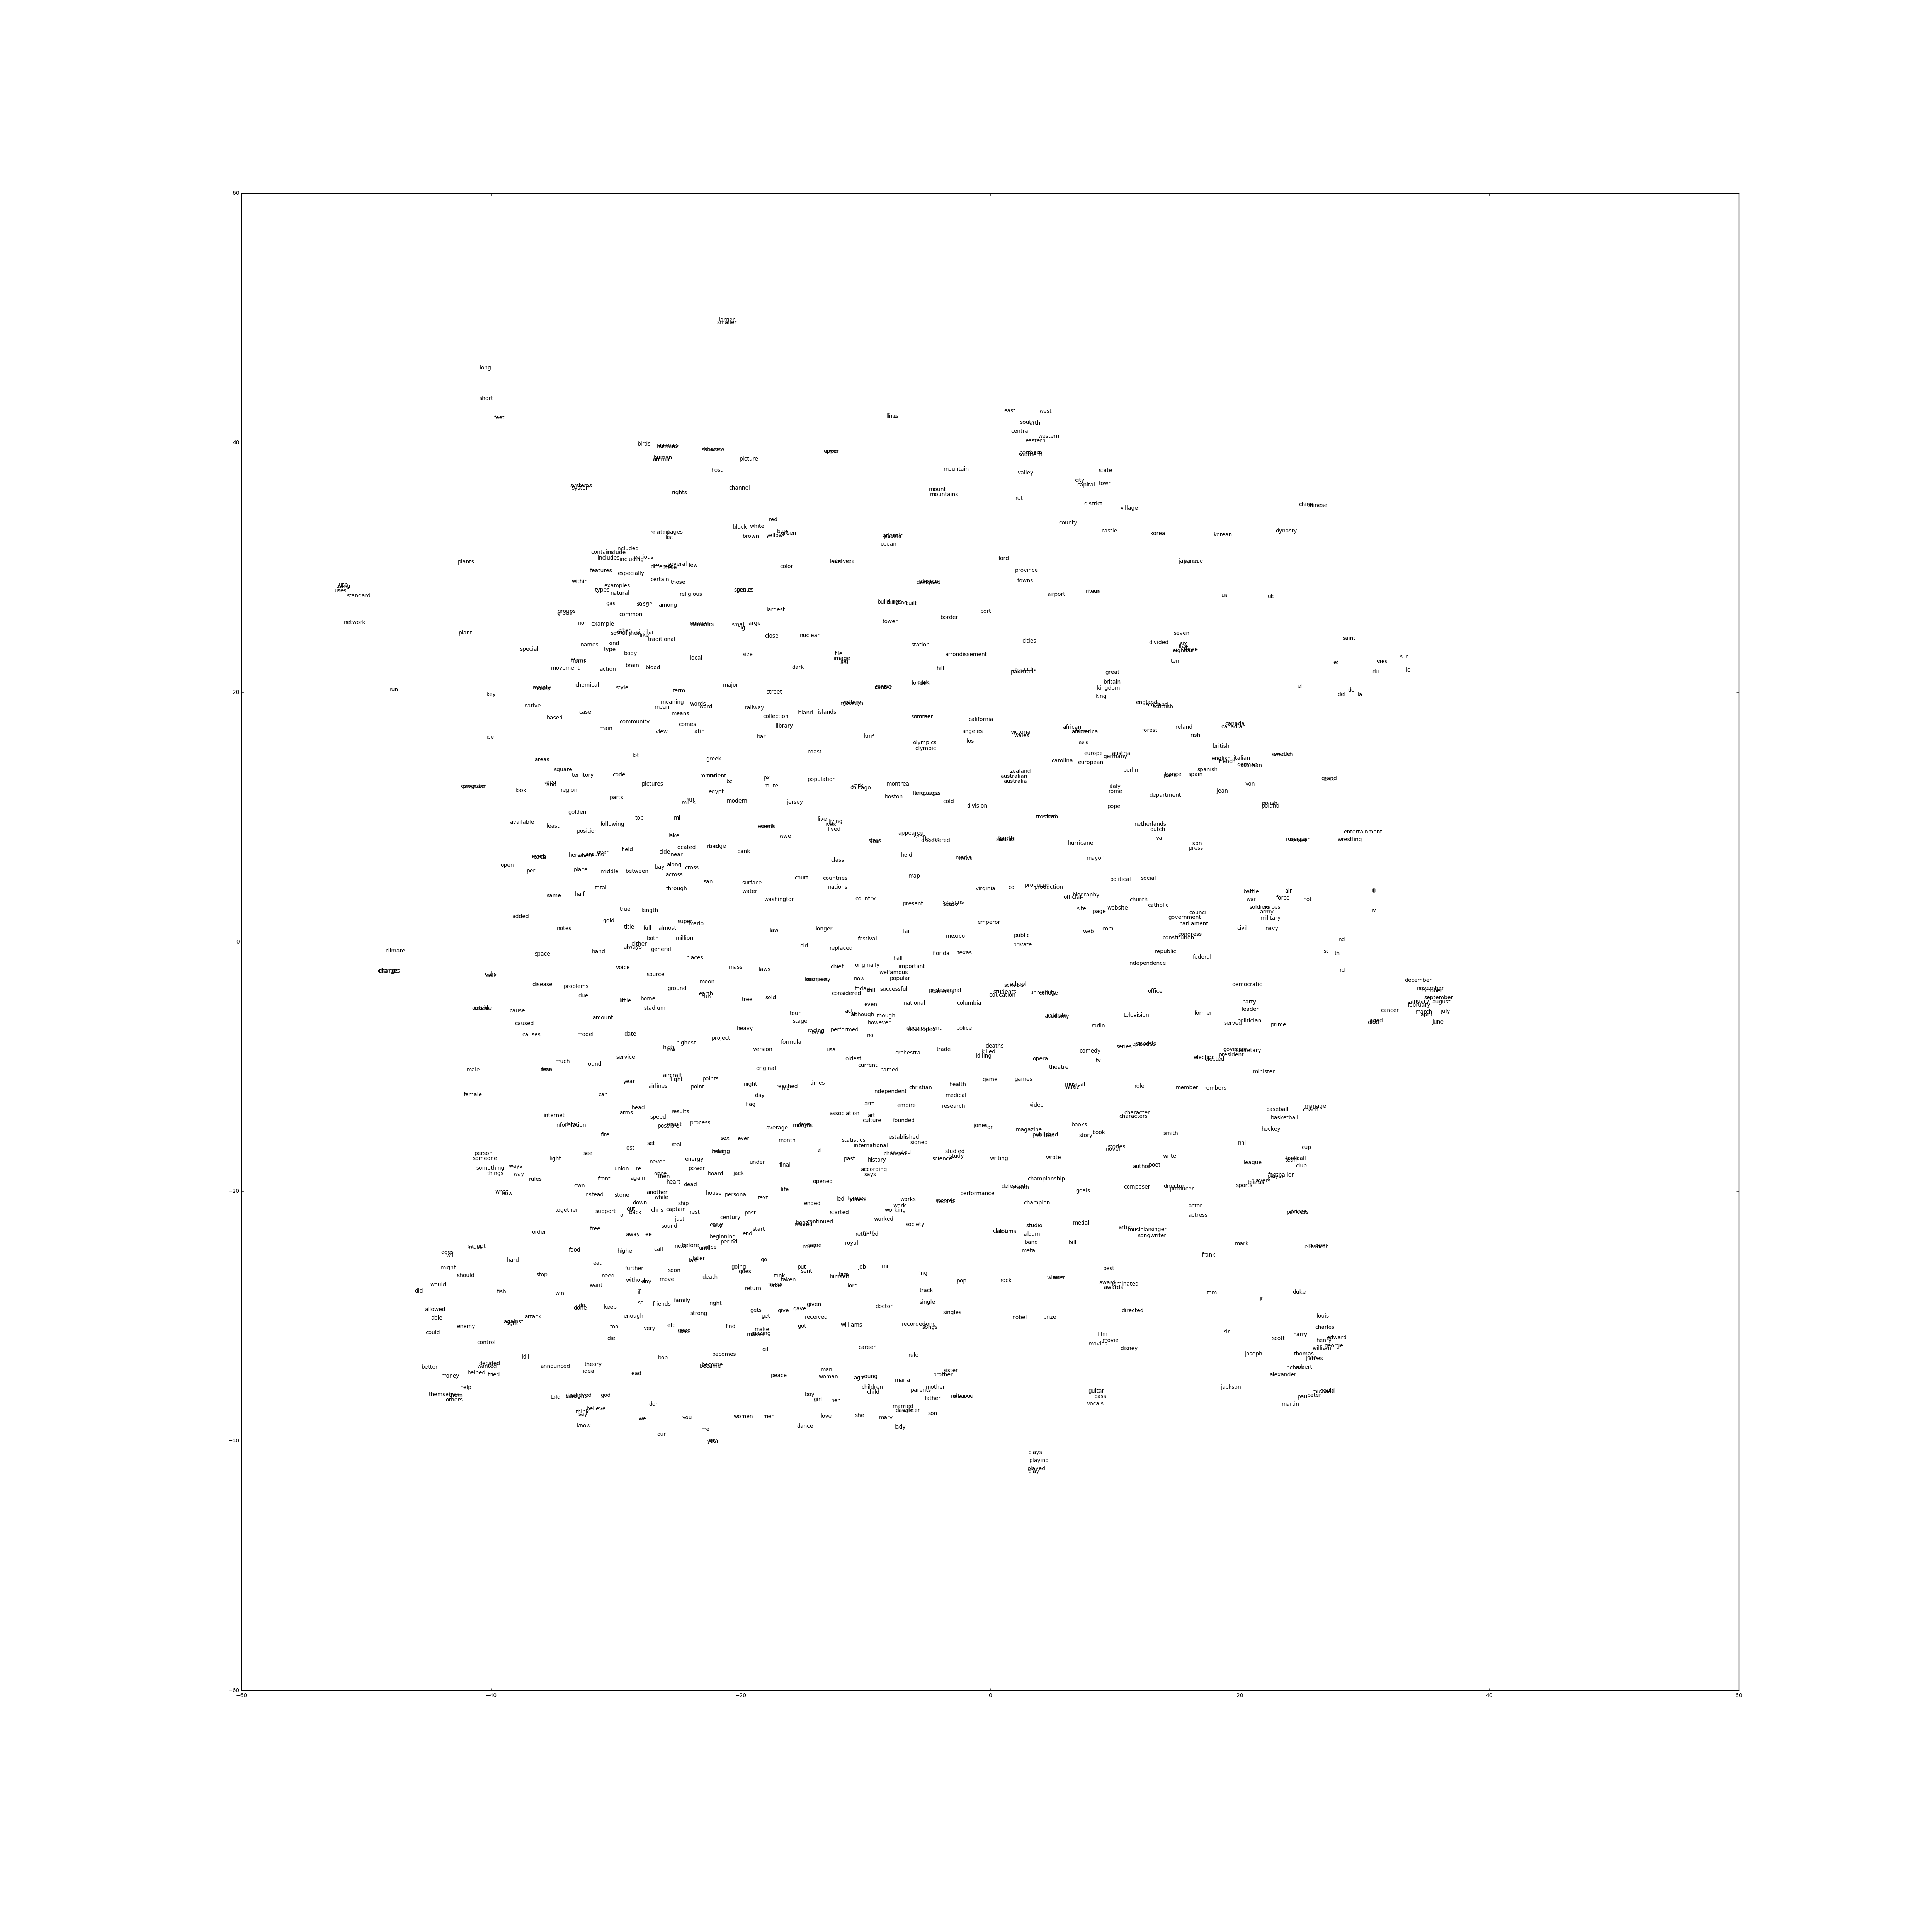

In [51]:
tsne = TSNE(n_components=2,perplexity=10,n_iter=1000,init='pca',random_state=0x5EED1E55)
plot_only = 1000

low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only])
labels = [reverse_dictionary[i] for i in range(plot_only)]
# Step 6: Visualize the embeddings.

def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    figure = plt.figure(figsize=(50,50),dpi=200) 
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y, alpha=0)
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', ha='center',
                     va='center')
    if filename is not None:
        figure.savefig(filename)
        plt.close(figure)


plot_with_labels(low_dim_embs, labels)

Image(filename='tsne.png') 

## GloVe

Данная модель пытается объединить в себе две идеи:
1. Факторизация матрицы, как в LSA
2. А вот контекстом слова является скользящее окно, как в v2w.

Пусть есть некоторая матрица $X$, где элемент $x_{ij}$ - это количество, сколько раз слово $j$ встрелось в контексте слова $i$. Эта матрица заполняется на основе нашего корпуса. Тогда вероятность, что слово $j$ появляется в контексте слова $i$ равна

$$P_{ij} = \frac{X_{ij}}{\sum_k X_{ik}}$$

При этом мы хотели бы найти такую функцию $F$ и представления для слов, что
$$F((w_i - w_j)^T w_k) = \frac{F(w_i^T w_k)}{F(w_j^T w_k)} = \frac{P_{ik}}{P_{jk}}$$
мотивировку именно такой модели лучше посомтреть в оригинальной [статье](http://nlp.stanford.edu/pubs/glove.pdf).
Возможное решение выглядит так

$$\exp(w_i^T w_j) = P_{ij}$$

Если немного поколдовать, то получится, что наша модели выглядит
$$w_i^T w_j = \log X_{ij} - \log\big(\sum_k X_{ik}\big)$$

Не сложно заметить, что второй член не зависит от $j$, однако итоговую модель все же предлагается для симметричности записать как

$$w_i^T w_j + b_i + b_j = \log X_{ij}$$

В качестве функции потерь можно использовать взвешенное квадратичное отклонение
$$\mathcal{L} = \sum_{i,j = 1}^{|W|} f(X_{ij}) \Big(w_i^T w_j + b_i + b_j - \log(X_{ij}) \Big)^2,$$
где функция $f$ определяет вес каждой пары слов. Разумно хранить матрицу $X_{ij}$ в виде разреженном виде. При этом примечательно то, что во время обучения авторы используют **только не нулевые** значения $X_{ij}$. Обучение ведется с помощью градиентного спуска, когда ненулевые значения просто семплируются из $X_{ij}$.

**Задание**
1. Оцените сложность модели. На основе оценки сложности поймите, какое $d$ и $c$ для вас оптимально.
2. Попробуйте обучить модель GloVe.
3. Убедитесь, что опять вектор v(king) - v(man) + v(women) ближе всего к v(queen).
4. Самостоятельно разберитесь, что такое [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding).
5. Используя t-SNE сожмите представления до 3-мерных векторов. Убедитесь, что следующие группы векторов примерно сонаправлены
  * [мужчина, женищина] (к примеру, [man, woman], [Mr., Ms], [king, queen] и.т.д)
  * [CEO, компания]
  * [прилагательное, его сравнительная форма]
5. Преложите метрику сравнения моделей (ее можно подсмотреть ;)).
6. Попробуйте семплировать также и нулевые значения матрицы $X_{ij}$. Ухудшилась ли модель?


In [52]:
class GloVeModel():
    def __init__(self, embedding_size, context_size, max_vocab_size=100000, 
                 scaling_factor=0.75, cooccurrence_cap=100, batch_size=512, learning_rate=0.05):
        self.embedding_size = embedding_size
        if isinstance(context_size, tuple):
            self.left_context, self.right_context = context_size
        elif isinstance(context_size, int):
            self.left_context = self.right_context = context_size
        else:
            raise ValueError("`context_size` should be an int or a tuple of two ints")
        self.max_vocab_size = max_vocab_size
        self.scaling_factor = scaling_factor
        self.cooccurrence_cap = cooccurrence_cap
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.__words = None
        self.__word_to_id = None
        self.__cooccurrence_matrix = None
        self.__embeddings = None

    def fit_to_corpus(self):
        self.__fit_to_corpus(self.max_vocab_size,
                             self.left_context, self.right_context)
        self.__build_graph()

    def __fit_to_corpus(self, vocab_size,  left_size, right_size):
        word_counts = Counter()
        cooccurrence_counts = defaultdict(float)
        for line in wiki.get_texts():
            l=[i.decode() for i in line if i in vm]
            word_counts.update(l)
            for l_context, word, r_context in _context_windows(l, left_size, right_size):
                for i, context_word in enumerate(l_context[::-1]):
                    # add (1 / distance from focal word) for this pair
                    cooccurrence_counts[(word, context_word)] += 1 / (i + 1)
                for i, context_word in enumerate(r_context):
                    cooccurrence_counts[(word, context_word)] += 1 / (i + 1)
        if len(cooccurrence_counts) == 0:
            raise ValueError("No coccurrences in corpus. Did you try to reuse a generator?")
        self.__words = [word for word, count in word_counts.most_common(vocab_size)]
        self.__word_to_id = {word: i for i, word in enumerate(self.__words)}
        self.__cooccurrence_matrix = {
            (self.__word_to_id[words[0]], self.__word_to_id[words[1]]): count
            for words, count in cooccurrence_counts.items()}

    def __build_graph(self):
        self.__graph = tf.Graph()
        with self.__graph.as_default(), self.__graph.device(_device_for_node):
            count_max = tf.constant([self.cooccurrence_cap], dtype=tf.float32,
                                    name='max_cooccurrence_count')
            scaling_factor = tf.constant([self.scaling_factor], dtype=tf.float32,
                                         name="scaling_factor")

            self.__focal_input = tf.placeholder(tf.int32, shape=[self.batch_size],
                                                name="focal_words")
            self.__context_input = tf.placeholder(tf.int32, shape=[self.batch_size],
                                                  name="context_words")
            self.__cooccurrence_count = tf.placeholder(tf.float32, shape=[self.batch_size],
                                                       name="cooccurrence_count")

            focal_embeddings = tf.Variable(
                tf.random_uniform([self.vocab_size, self.embedding_size], 1.0, -1.0),
                name="focal_embeddings")
            context_embeddings = tf.Variable(
                tf.random_uniform([self.vocab_size, self.embedding_size], 1.0, -1.0),
                name="context_embeddings")

            focal_biases = tf.Variable(tf.random_uniform([self.vocab_size], 1.0, -1.0),
                                       name='focal_biases')
            context_biases = tf.Variable(tf.random_uniform([self.vocab_size], 1.0, -1.0),
                                         name="context_biases")

            focal_embedding = tf.nn.embedding_lookup([focal_embeddings], self.__focal_input)
            context_embedding = tf.nn.embedding_lookup([context_embeddings], self.__context_input)
            focal_bias = tf.nn.embedding_lookup([focal_biases], self.__focal_input)
            context_bias = tf.nn.embedding_lookup([context_biases], self.__context_input)

            weighting_factor = tf.minimum(
                1.0,
                tf.pow(
                    tf.div(self.__cooccurrence_count, count_max),
                    scaling_factor))

            embedding_product = tf.reduce_sum(tf.mul(focal_embedding, context_embedding), 1)

            log_cooccurrences = tf.log(tf.to_float(self.__cooccurrence_count))

            distance_expr = tf.square(tf.add_n([
                embedding_product,
                focal_bias,
                context_bias,
                tf.neg(log_cooccurrences)]))

            single_losses = tf.mul(weighting_factor, distance_expr)
            self.__total_loss = tf.reduce_sum(single_losses)
            self.__optimizer = tf.train.AdagradOptimizer(self.learning_rate).minimize(
                self.__total_loss)

            self.__combined_embeddings = tf.add(focal_embeddings, context_embeddings,
                                                name="combined_embeddings")

    def train(self, num_epochs, log_dir=None, summary_batch_interval=1000,
              tsne_epoch_interval=None):
        should_write_summaries = log_dir is not None and summary_batch_interval
        should_generate_tsne = log_dir is not None and tsne_epoch_interval
        batches = self.__prepare_batches()
        total_steps = 0
        average_loss = 0
        with tf.Session(graph=self.__graph) as session:
            tf.global_variables_initializer().run()
            for epoch in range(num_epochs):
                shuffle(batches)
                for batch_index, batch in enumerate(batches):
                    i_s, j_s, counts = batch
                    if len(counts) != self.batch_size:
                        continue
                    feed_dict = {
                        self.__focal_input: i_s,
                        self.__context_input: j_s,
                        self.__cooccurrence_count: counts}
                    _, loss_val = session.run([self.__optimizer,self.__total_loss], feed_dict=feed_dict)
                    average_loss += loss_val
                    if total_steps % 2000 == 0:
                        if total_steps > 0:
                            average_loss /= 2000
                        print("Average loss at step ", total_steps, ": ", average_loss)
                        average_loss = 0
                    total_steps += 1
            self.__embeddings = self.__combined_embeddings.eval()
            if should_write_summaries:
                summary_writer.close()

    def embedding_for(self, word_str_or_id):
        if isinstance(word_str_or_id, str):
            return self.embeddings[self.__word_to_id[word_str_or_id]]
        elif isinstance(word_str_or_id, int):
            return self.embeddings[word_str_or_id]

    def __prepare_batches(self):
        if self.__cooccurrence_matrix is None:
            raise NotFitToCorpusError(
                "Need to fit model to corpus before preparing training batches.")
        cooccurrences = [(word_ids[0], word_ids[1], count)
                         for word_ids, count in self.__cooccurrence_matrix.items()]
        i_indices, j_indices, counts = zip(*cooccurrences)
        return list(_batchify(self.batch_size, i_indices, j_indices, counts))

    @property
    def vocab_size(self):
        return len(self.__words)

    @property
    def words(self):
        if self.__words is None:
            raise NotFitToCorpusError("Need to fit model to corpus before accessing words.")
        return self.__words

    @property
    def embeddings(self):
        if self.__embeddings is None:
            raise NotTrainedError("Need to train model before accessing embeddings")
        return self.__embeddings

    def id_for_word(self, word):
        if self.__word_to_id is None:
            raise NotFitToCorpusError("Need to fit model to corpus before looking up word ids.")
        return self.__word_to_id[word]

    def generate_tsne(self, path=None, size=(40, 40), word_count=1000, embeddings=None):
        if embeddings is None:
            embeddings = self.embeddings
        from sklearn.manifold import TSNE
        tsne = TSNE(perplexity=10, n_components=2, init='pca', n_iter=1000)
        low_dim_embs = tsne.fit_transform(embeddings[:word_count, :])
        labels = self.words[:word_count]
        return _plot_with_labels(low_dim_embs, labels, path, size)


def _context_windows(region, left_size, right_size):
    for i, word in enumerate(region):
        start_index = i - left_size
        end_index = i + right_size
        left_context = _window(region, start_index, i - 1)
        right_context = _window(region, i + 1, end_index)
        yield (left_context, word, right_context)


def _window(region, start_index, end_index):
    """
    Returns the list of words starting from `start_index`, going to `end_index`
    taken from region. If `start_index` is a negative number, or if `end_index`
    is greater than the index of the last word in region, this function will pad
    its return value with `NULL_WORD`.
    """
    last_index = len(region) + 1
    selected_tokens = region[max(start_index, 0):min(end_index, last_index) + 1]
    return selected_tokens


def _device_for_node(n):
    if n.type == "MatMul":
        return "/gpu:0"
    else:
        return "/cpu:0"


def _batchify(batch_size, *sequences):
    for i in range(0, len(sequences[0]), batch_size):
        yield tuple(sequence[i:i+batch_size] for sequence in sequences)


def _plot_with_labels(low_dim_embs, labels, path, size):
    import matplotlib.pyplot as plt
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    figure = plt.figure(figsize=size)  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right',
                     va='bottom')
    if path is not None:
        figure.savefig(path)
        plt.close(figure)

In [53]:
model=GloVeModel(embedding_size=256,context_size=6)

In [ ]:
model.fit_to_corpus()

2017-02-24 22:53:22,022 : INFO : finished iterating over Wikipedia corpus of 80817 documents with 21819318 positions (total 225974 articles, 23132907 positions before pruning articles shorter than 50 words)


In [ ]:
model.train(20)

Average loss at step  0 :  570.531616211
Average loss at step  2000 :  470.369497772
Average loss at step  4000 :  420.478736755
Average loss at step  6000 :  391.054184662
Average loss at step  8000 :  366.473818153
Average loss at step  10000 :  346.248923775
Average loss at step  12000 :  331.927149574
Average loss at step  14000 :  319.321664925
Average loss at step  16000 :  308.707995064
Average loss at step  18000 :  297.803599098
Average loss at step  20000 :  286.711049057
Average loss at step  22000 :  279.643933418
Average loss at step  24000 :  271.872090065
Average loss at step  26000 :  262.201214531
Average loss at step  28000 :  257.138129936
Average loss at step  30000 :  249.208059357
Average loss at step  32000 :  245.52368763
Average loss at step  34000 :  239.190835106
Average loss at step  36000 :  235.010584991
Average loss at step  38000 :  227.920440193
Average loss at step  40000 :  223.86477623
Average loss at step  42000 :  219.705746849
Average loss at step

In [ ]:
emb_glove=model.embeddings

In [ ]:
get_nn('cat',emb_glove,lambda x: model.words[x],model.id_for_word,scipy.spatial.distance.cosine)

In [ ]:
get_nn('april',emb_glove,lambda x: model.words[x],model.id_for_word,scipy.spatial.distance.euclidean)

In [ ]:
model.generate_tsne('glove_tsne.png')
Image(filename='glove_tsne.png')

In [ ]:
get_sub_add_nn('king','man','woman',emb_glove,lambda x: model.words[x],model.id_for_word,scipy.spatial.distance.cosine)

In [ ]:
get_sub_add_nn('men','man','dog',emb_glove,lambda x: model.words[x],model.id_for_word)

7 Сравните все три модели.

Воспользуемся датасетом [Google analogy test set]
(http://download.tensorflow.org/data/questions-words.txt) и измерим на нём точность полученных представлений следующим образом: если хотя бы один из 10 предложенных моделью вариантов совпадает с истинным, засчитывать 1, иначе - 0. Итоговой метрикой будет относительная точность.

8 А теперь дайте остыть вашей ЖПУ и идите спать.

In [ ]:
questions=[]
with open('questions-words.txt') as f:
    for line in f:
        if not line.startswith(':'):
            questions.append(line.split())

In [ ]:
corr=[0]*4
for question in questions:
    if question[2].lower() in get_sub_add_nn(question[0],question[1],question[3],
                                             emb_svd,lambda x: wiki.dictionary[x],
                                             lambda x: wiki.dictionary.doc2bow([x])):
        corr[0]+=1
    if question[2].lower() in get_sub_add_nn(question[0],question[1],question[3],
                                             final_embeddings,lambda x: reverse_dictionary[x],
                                             lambda x: dictionary[x]):
        corr[1]+=1
    if question[2].lower() in get_sub_add_nn(question[0],question[1],question[3],
                                             emb_glove,lambda x: model.words[x],
                                             model.id_for_word):
        corr[2]+=1